In [20]:
import matplotlib.pyplot as plt
import numpy as np
from dynamicalsystems.lorenz93 import Lorenz93Model

plt.style.use("Solarize_Light2")
%matplotlib inline
from filters.standardPF import BootstrapPF
from filters.optimalparticlefilter import OptimalKPF


## Model definition and example of forward model
We import the Lorenz93Model class, set its dimension (as a class variable)

In [21]:
# Set class variable
state_dimension = 40
Lorenz93Model.dim = state_dimension
# lorenz40 = Lorenz93Model()
# x0 = np.random.normal(0, 1, lorenz40.dim)
# lorenz40.set_initial_state(0, x0)
# lorenz40.forward(500)
# plt.imshow(lorenz40.state_vector, aspect="auto")

## Truth definition
We introduce the "truth", which is a Lorenz93Model, with specified initial condition. We use a burn-in period of 1000 timesteps

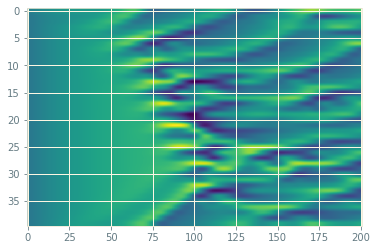

In [22]:
truth = Lorenz93Model()
x0 = np.zeros(state_dimension)
x0[0] = 1
burn = 200
truth.set_initial_state(-burn * truth.dt, x0)
truth.forward(burn)
plt.imshow(truth.state_vector, aspect="auto")

We define a function to generate a projector,  observation operator $H$:


In [23]:
def create_projector(n: int, m: int, indices) -> np.ndarray:
    """Create a projector from a space of n dimension to m, where the identity is applied to the indices 

    :param n: input dimension
    :type n: int
    :param m: output dimension
    :type m: int
    :param indices: indices to keep
    :type indices: Iterable
    :return: Projection matrix
    :rtype: np.ndarray
    """    
    H = np.zeros((m, n))
    for i in indices:
        H[i, i] = 1
    return H

In [24]:
period_assim = 2
sigobs = 1
dim_observations = state_dimension // 2
H = create_projector(state_dimension, dim_observations, np.arange(dim_observations))
R = sigobs * np.eye(dim_observations)
Q = .5 * np.eye(state_dimension)


In [25]:
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.randn(state_dimension) * sigobs
    return truth.t[-1], y

In [26]:
Nparticles = 2000

PF = OptimalKPF(state_dimension, Nparticles, R, Q)

PF.set_forwardmodel(lambda x: Lorenz93Model.integrate(
    0, x, period_assim,)[1][:, -1] + np.random.multivariate_normal(np.zeros(state_dimension), cov=Q))
PF.H = H
# PF.R = R #TODO verify how to call properly the setter at the __init__
siginit = 1.0
initial_state = truth.state_vector[:, -1]
covariance = siginit * np.eye(state_dimension)
PF.generate_particles(mean=initial_state, cov=covariance)



In [27]:
Nsteps = 100
dPF = PF.run(Nsteps, generate_observations)

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'obs_dimension' is not defined

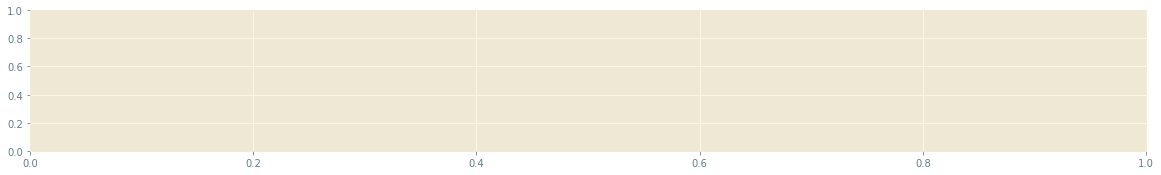

In [37]:
est = np.array(dPF["estimates"])[:, 0, :].T
std = np.sqrt(np.array(dPF["estimates"])[:, 1, :]).T
obs = np.array(dPF["observations"]).T
wei = np.array(dPF["weights"])

plt.figure(figsize=(20,15))
for i, ind in enumerate([0, 7, 15, 31, 39]):
    plt.subplot(5, 1, i + 1)
    if ind < dim_observations:
        plt.title(f"Observed variable")
    else:
        plt.title(f"Unobserved variable")
    plt.plot(truth.t[(burn+1):], truth.state_vector[ind, (burn+1):])
    plt.scatter(dPF["time"], obs[ind, :], marker="o", c="red", s=20)
    plt.scatter(dPF["time"], est[ind, :], marker="x", color="blue", s=20)
    plt.fill_between(dPF['time'], (est + 3*std)[ind, :], (est - 3*std)[ind, :], alpha=0.2)
plt.show()

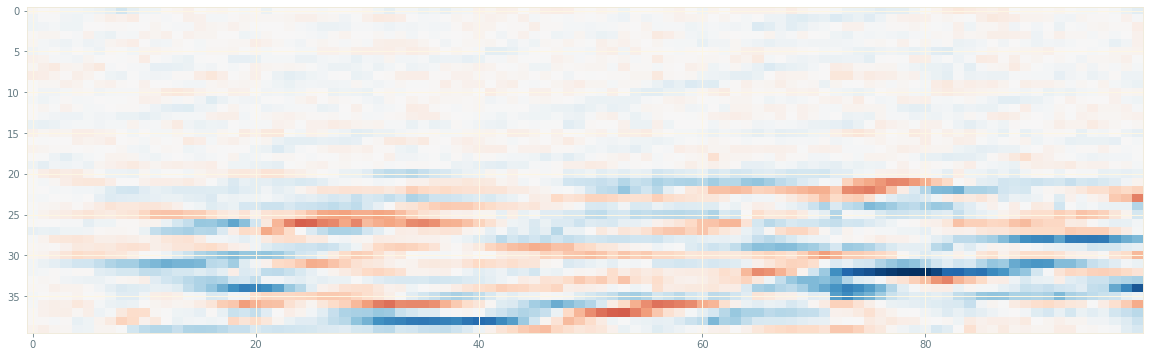

In [29]:
analysis_error = truth.state_vector[:, (burn+1)::period_assim] - est
mi, ma = analysis_error.min(), analysis_error.max()
lim = max(np.abs(mi), np.abs(ma))
plt.figure(figsize=(20, 6))
plt.imshow(analysis_error, vmin=-lim, vmax=lim, cmap='RdBu', aspect='auto')

In [33]:
analysis_error = est - truth.state_vector[:, (burn+period_assim)::period_assim]
observation_error = obs - truth.state_vector[:, (burn+period_assim)::period_assim]
ea = ((analysis_error)**2).mean()
eo = ((observation_error)**2).mean()
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

     Analysis error:     11.0290647599008
  Observation error:   1.0040331410644319


(40, 100)